<a href="https://colab.research.google.com/github/Daalma7/ProyectoVC/blob/master/proyectoVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Para empezar, vamos a importar las librerías necesarias y a especificar parámetros necesarios. Habilitamos uso de GPU, y ponemos una semilla aleatoria para intentar controlar la reproducibilidada de los experimentos

Vamos a importar funciones auxiliares que hemos utilizado en otras prácticas anteriores que nos servirán para calcular mostrar resultados. Además vamos a definir una función  que servirá para especificar cómo se deben leer las imágenes que utilizaremos en nuestro estudio

In [ ]:
# Importar librerías necesarias
import tensorflow as tf
import numpy as np
import keras
import keras.utils as np_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import MobileNet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.applications import DenseNet121
from keras.applications.resnet import ResNet50
from keras.applications import VGG19,InceptionV3,Xception
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm


#OJO aquí habilito uso de GPU. Desactivar luego

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

tf.device('/device:GPU:0')


# Importar el optimizador a usar
from keras.optimizers import SGD

# Importar modelos y capas específicas que se van a usar
from keras.preprocessing.image import ImageDataGenerator

#Path donde se encontrarán las imágenes del proyecto
path = '/content/drive/MyDrive/GoogleColab/proyectoImagenes'

#Semilla aleatoria para controlar las ejecuciones del programa y garantizar reproducibilidad
np.random.seed(50)

In [ ]:
"""------------------------FUNCIONES AUXILIARES DE PRÁCTICAS ANTERIORES----------------------------"""

def pintaI(image, flag_color=1, image_title = "Imagen", window_title = "Ejercicio"):
    #image=cv.normalize(image, None, 0.0, 1.0, cv.NORM_MINMAX)
    image = image.astype(np.uint8)
    plt.figure(0).canvas.set_window_title(window_title) # Ponemos nombre a la ventana
    if flag_color == 0:
        plt.imshow(image, cmap = "gray")
    else:
        plt.imshow(image)
    plt.title(image_title)              # Ponemos nombre a la imagen
    plt.show()
    image = image.astype(np.float64)    # Devolvemos su formato

def calcularAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmax(preds, axis = 1)
    accuracy = sum(labels == preds)/len(labels)
    return accuracy

def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.ylim(0,1)           #Meto esto para mejor comparación de gráficas
    plt.show()

"""------------------------------------LECTURA DE IMÁGENES ----------------------------------------"""

def leerImagenes(clases, num_imgs, path):
  
  imgs_covid = np.array([img_to_array(load_img(path + "/" + clases[i] + "/" + clases[i] + " (" + str(i+1) + ").png",
                                                target_size = (224, 224), interpolation="bilinear")) for i in range(0,num_imgs)])
  imgs_normal = np.array([img_to_array(load_img(path + "/" + clases[i] + "/" + clases[i] + " (" + str(i-num_imgs+1) + ").png",
                                                target_size = (224, 224), interpolation="bilinear")) for i in range(num_imgs,2*num_imgs)])
  imgs_viral = np.array([img_to_array(load_img(path + "/" + clases[i] + "/" + clases[i] + " (" + str(i-2*num_imgs+1) + ").png", 
                                                target_size = (224, 224), interpolation="bilinear")) for i in range(2*num_imgs,3*num_imgs)])

  return imgs_covid, imgs_normal, imgs_viral

Vamos a generar primero las etiquetas sabiendo que hay 1200 imágenes positivas de COVID, 1341 imágenes normales y 1345 imágenes de neumonía vírica. Especificamos el número de imágenes de cada clase que vamos a usar en nuestro estudio con el parámetro num_imgs

In [ ]:
#Genero primero las etiquetas sabiendo que hay 1200 imágenes positivas de COVID, 1341 imágenes normales
#y 1345 imágenes de neumonía vírica

#Elegimos el número de imágenes por clase que vamos a utilizar
num_imgs=1200
clases=[]
for i in range(1,3*num_imgs+1):
  if (i<=num_imgs):
    clases.append('COVID')
  elif (i<=2*num_imgs):
    clases.append('NORMAL')
  else:
    clases.append('Viral Pneumonia')




imgs_covid, imgs_normal, imgs_viral = leerImagenes(clases,num_imgs, path)
#imagenes = np.array([img_to_array(load_img(path + "/COVID/" + "COVID (1).png"))])

print("Se han leido ", len(imgs_covid) + len(imgs_normal) + len(imgs_viral), " imagenes.")

Se han leido  3600  imagenes.


Vamos a mostrar algunos de ejemplos de las imágenes que conforman el dataset.

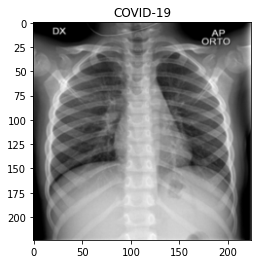

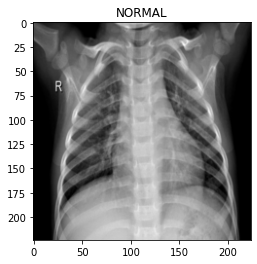

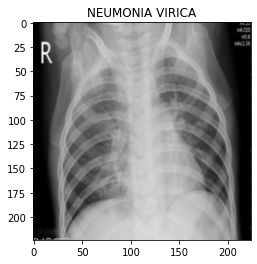

In [ ]:
#Un ejemplo del dataset de imágenes
pintaI(imgs_covid[4],0, 'COVID-19')
pintaI(imgs_normal[4],0, 'NORMAL')
pintaI(imgs_viral[4],0, 'NEUMONIA VIRICA')


Vamos a crear ahora los conjuntos de entrenamiento y de test, en base a las imágenes que hemos leído. La partición que tenemos actualmente puede hacer que se consigan resultados muy buenos, hay que probar con otro tipo de particiones a ver si es cosa de que el problema en sí es muy fácil de predecir, o a caso es que estamos incluyendo elementos que hacen más fácil la predicción, como varias imágenes de la misma persona tanto en entrenamiento como en test

In [ ]:
"""-------------Creamos los conjuntos de train y test ----------------------"""

#Creamos un array con todas las imágenes
imagenes = np.concatenate((imgs_covid, imgs_normal, imgs_viral), axis=0)

# Pasamos los vectores de las clases a matrices 
# Para ello, primero pasamos las clases a números enteros
clases_posibles = ["COVID","NORMAL","Viral Pneumonia"]
for i in range(3):
  for j in range(len(clases)):
    if (clases[j] == clases_posibles[i]):
      clases[j] = i
      

# Después, usamos la función to_categorical()
clases = np_utils.to_categorical(clases, num_classes=3)

# Barajar los datos
imagenes_perm = np.random.permutation(len(imagenes))
imagenes = imagenes[imagenes_perm]
clases = clases[imagenes_perm]

#Separamos los datos en train y test con una proporción de 80-20 %
sep = int (3*num_imgs*0.8)
x_train = imagenes[:sep]
y_train = clases[:sep]

x_test = imagenes[sep:]
y_test = clases[sep:]

print("Cantidad de datos por conjunto:\n train: ", len(x_train), "\n test: ", len(x_test))

Cantidad de datos por conjunto:
 train:  2880 
 test:  720


Cosas fundamentales a hacer y explicar en el PDF:

- Hacer image normalization.
 - La normalización debería ser featurewise (en todo el conjunto de entrenamiento) como mínimo, medida 0 y desviación 1.
 -Hay imágenes que salen muy blancas y otras imágenes que salen muy oscuras, y por lo tanto deberíamos conseguir invarianza frente al brillo, por lo que añado el parámetro de brightness.
 -Se entiende que los pulmones siempre se sacan verticales, por lo que no tiene mucho sentido añadir rotaciones, pero sí flips horizontales.
 -Zooms de ampliación pueden ser interesantes, puesto que las imágenes tienen siempre los pulmones en la zona central, y podemos evitar posibles fuentes de ruido de letras que tienen algunas de las imágenes en las zonas laterales, que se perderán haciendo zoom.

- Discutir más tipos de data augmentation, si puede hacerse algo sobre inspiración y expiración.

#Modelo basado en DenseNet121

Vamos a comenzar usando esta red, preentrenada con IMAGENET, como base para desarrollar nuestro modelo.

Definición inicial del modelo:

In [ ]:
#Definición inicial de nuestro modelo preentrenado en imagenet.
#Para usarlo como extractor de características simple

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = DenseNet121(include_top=False, weights='imagenet', pooling='avg')
feat_extractor.trainable = False

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict(x_train, verbose=1)
car_test = feat_extractor.predict(x_test, verbose=1)

print(len(car_train))
print(len(car_train[0]))
print(len(car_test))
print(len(car_test[0]))


#feat_extractor.summary()

23/23 [==============================] - 4s 117ms/step
2880
1024
720
1024


## Versión 0: Extractor de características inicial, sin entrenamiento
Primero vamos a utilizar el modelo DenseNet121 preentrenada con IMAGENET sin entrenar ningún peso. Partiendo de las características extraidas, simplemente vamos a añadir la capa softmax y comprobaremos que los resultados no son para nada buenos, pues todavía no hemos entrenado nuevos pesos, no estamos adaptando la red a nuestros datos en absoluto.

In [ ]:
inputs = keras.layers.Input(shape=[1024])
outputs = keras.layers.Dense(units=3, activation="softmax")(inputs)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))


23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.3263888888888889
La matriz de confusión de las predicciones ha sido: 
 [[235   0   0]
 [244   0   0]
 [241   0   0]]


## Versión 1: Extractor de características inicial, entrenando la capa de salida
Ahora vamos a reentrenar sólo la capa de salida, sin ningún tratamiento adicional.



Definir el modelo a entrenar y ejecutarlo

Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 28.0820 - acc: 0.6940 - val_loss: 3.1809 - val_acc: 0.8542
Epoch 2/20
81/81 [==============================] - 0s 2ms/step - loss: 5.2230 - acc: 0.8450 - val_loss: 1.3767 - val_acc: 0.9167
Epoch 3/20
81/81 [==============================] - 0s 2ms/step - loss: 2.1800 - acc: 0.9132 - val_loss: 2.0817 - val_acc: 0.8889
Epoch 4/20
81/81 [==============================] - 0s 2ms/step - loss: 1.9926 - acc: 0.9087 - val_loss: 2.4408 - val_acc: 0.9097
Epoch 5/20
81/81 [==============================] - 0s 2ms/step - loss: 2.0064 - acc: 0.9112 - val_loss: 1.1532 - val_acc: 0.9549
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 1.9035 - acc: 0.9233 - val_loss: 4.3114 - val_acc: 0.8542
Epoch 7/20
81/81 [==============================] - 0s 2ms/step - loss: 1.4699 - acc: 0.9210 - val_loss: 2.8389 - val_acc: 0.8785
Epoch 8/20
81/81 [==============================] - 0s 2ms/step - loss: 1.4968 - acc: 0.9

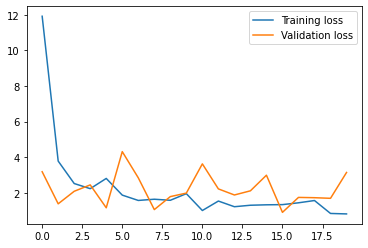

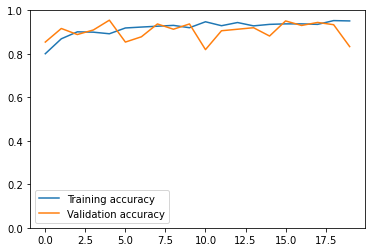

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.8361111111111111
La matriz de confusión de las predicciones ha sido: 
 [[231   1   3]
 [  6 135 103]
 [  5   0 236]]


In [ ]:
#Modelo denso
inputs = keras.layers.Input(shape=[1024])
outputs = keras.layers.Dense(units=3, activation="softmax")(inputs)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

Como podemos ver, los resultados son bastante buenos, conseguimos un 90% de accuracy en los conjuntos tanto de validación como de test. Esto nos llevará a no enfocar el estudio tanto a mejorar la calidad de la red, sino a obtener otro tipo de información de interés y hacer otras comprobaciones y análisis comparativos.

- En primer lugar, intentaremos mejorar la calidad de la red obtenida con otras técnicas un poco más sofisticadas, ya que la que hemos empleado ahora mismo es extremadamente simple, y entendemos que todavía hay bastante margen de mejora.

- En segundo lugar, intentaremos, sobre la red que nos haya dado mejores resultados, intentar comprender qué información se extrae de la red, visualizando los campos receptivos de algunas neuronas para las imágenes que mayor activación hayan dado en ellas.

- Realizaremos también un estudio comparativo entre utilizar diferentes tipos de redes como base. Inicialmente hemos usado Densenet121, pero hay otras muchas redes que keras nos aporta ya preentrenadas en imagenet, con lo que podremos comparar sus funcionamientos dentro del mismo problema.

- Intentar hacer una red desde cero (from scratch) y comparar la calidad en las predicciones obtenidas con las de los modelos preentrenados que hemos estado viendo

## Version 2: Data augmentation, más capas densas
Seguimos empleando la red preentreanda como extractor de características pero se realiza un preprocesado más exhaustivo de imágenes, con image augmentation y normalización, además de hacer un modelo denso de mayor profundidad. 

In [ ]:
#Image data generators
def generators(x_train):
  train_generator = ImageDataGenerator(featurewise_center = True,
                              featurewise_std_normalization = True,
                              validation_split=0.1,
                              horizontal_flip=True,
                              brightness_range=[0.8,1.25],
                              zoom_range=[1,1.2])
  train_generator.fit(x_train)

  test_generator = ImageDataGenerator(featurewise_center = True,
                              featurewise_std_normalization = True)

  test_generator.fit(x_train)

  return train_generator, test_generator

Ahora volvemos a hacer la predicción de características de las imágenes del modelo, pero esta vez usando el data augmentation que hemos definido en los ImageDataGenerators

In [ ]:
train_generator, test_generator = generators(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = DenseNet121(include_top=False, weights='imagenet', pooling='avg', )

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)
feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict_generator(train_generator.flow(x_train, batch_size=1, shuffle=False),verbose=1, steps=len(x_train))
car_test = feat_extractor.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

#feat_extractor.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 7s 10ms/step


Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 0.7081 - acc: 0.7616 - val_loss: 0.1490 - val_acc: 0.9583
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1394 - acc: 0.9528 - val_loss: 0.1610 - val_acc: 0.9479
Epoch 3/20
81/81 [==============================] - 0s 2ms/step - loss: 0.1002 - acc: 0.9692 - val_loss: 0.1066 - val_acc: 0.9722
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1065 - acc: 0.9632 - val_loss: 0.1065 - val_acc: 0.9722
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.0696 - acc: 0.9738 - val_loss: 0.1189 - val_acc: 0.9653
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 0.0647 - acc: 0.9784 - val_loss: 0.1063 - val_acc: 0.9618
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.0692 - acc: 0.9754 - val_loss: 0.0999 - val_acc: 0.9722
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.0461 - acc: 0.98

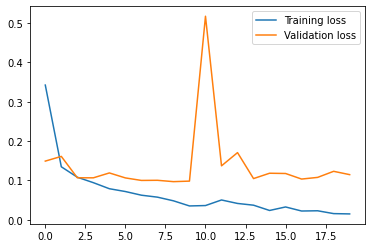

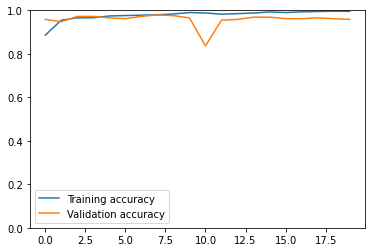

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.9597222222222223
La matriz de confusión de las predicciones ha sido: 
 [[230   3   2]
 [  1 238   5]
 [  1  17 223]]


In [ ]:
#Modelo denso
inputs = keras.layers.Input(shape=[1024])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dense(units=200, activation="relu")(layer1)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer2)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

En esta última versión 2 puede ser que tengamos un poco de overfitting puesto que el validation loss no decrece al mismo ritmo que el training loss.
Regularizamos añadiendo una capa de Dropout.

Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 0.5754 - acc: 0.7603 - val_loss: 0.1572 - val_acc: 0.9549
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2196 - acc: 0.9295 - val_loss: 0.1455 - val_acc: 0.9549
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1766 - acc: 0.9378 - val_loss: 0.1231 - val_acc: 0.9688
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1405 - acc: 0.9494 - val_loss: 0.1394 - val_acc: 0.9618
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1660 - acc: 0.9467 - val_loss: 0.1235 - val_acc: 0.9653
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1389 - acc: 0.9520 - val_loss: 0.1157 - val_acc: 0.9688
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1335 - acc: 0.9513 - val_loss: 0.1089 - val_acc: 0.9757
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1337 - acc: 0.95

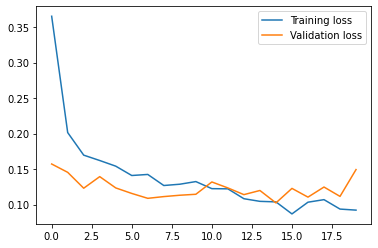

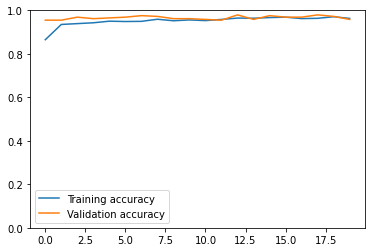

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.9569444444444445
La matriz de confusión de las predicciones ha sido: 
 [[226   2   7]
 [  0 233  11]
 [  0  11 230]]


In [ ]:
#Modelo denso
inputs = keras.layers.Input(shape=[1024])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dropout(0.5)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer3)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

##Version 3: Fine tunning

Vamos a probar ahora a hacer un ajuste fino de la red completa, tomando como pesos iniciales los de imagenet. Ahora ya no solo vamos a utilizar DenseNet como extractor de características, sino que, en vez de estar la red congelada, vamos a ir moviendo sus pesos con el entrenamiento

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 56s 576ms/step - loss: 0.4506 - acc: 0.8102 - val_loss: 4.6190 - val_acc: 0.5868
Epoch 2/20
81/81 [==============================] - 45s 550ms/step - loss: 0.1626 - acc: 0.9496 - val_loss: 0.3220 - val_acc: 0.8681
Epoch 3/20
81/81 [==============================] - 45s 553ms/step - loss: 0.1118 - acc: 0.9609 - val_loss: 0.0483 - val_acc: 0.9757
Epoch 4/20
81/81 [==============================] - 45s 551ms/step - loss: 0.0959 - acc: 0.9687 - val_loss: 0.2754 - val_acc: 0.9271
Epoch 5/20
81/81 [==============================] - 45s 549ms/step - loss: 0.0665 - acc: 0.9762 - val_loss: 0.1771 - val_acc: 0.9688
Epoch 6/20
81/81 [==============================] - 45s 549ms/step - loss: 0.0510 - acc: 0.9806 - val_loss: 0.3837 - val_acc: 0.8611
Epoch 7/20
81/81 [==============================] - 45s 550ms/step - loss: 0.0523 - acc: 0.9819 - val_loss: 0.0950 - val_acc: 0.9583
Epoch 8/20
81/81 [==============================] - 45s 550ms/step - 

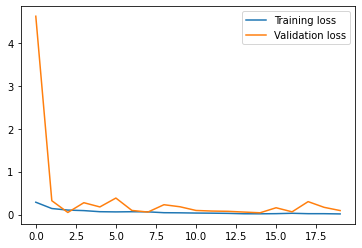

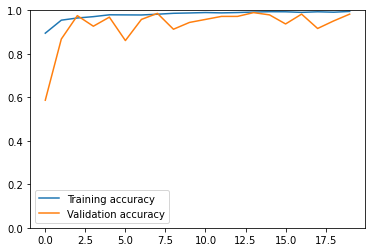

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 9s 10ms/step
La accuracy del modelo es: 0.9736111111111111
La matriz de confusión de las predicciones ha sido: 
 [[235   0   0]
 [  0 230  14]
 [  4   1 236]]


In [ ]:
#Fine Tunning
train_generator, test_generator = generators(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
denseNet = DenseNet121(include_top=False, weights='imagenet', pooling='avg', )

#Pesos sí entrenables
denseNet.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(denseNet.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=denseNet.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 20,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
#model.summary()
#Clasificamos
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

Como podemos observar en la matriz de confusión, hemos conseguido casi un 99% de accuracy con nuestro modelo. Como vemos, sólo ha habido 9 ejemplos clasificados erróneamente en la matriz de confusión, y entendemos que la calidad de este modelo es ya bastante buena. Habiendo conseguido una mejora sustancial con respecto al modelo de extracción de características simple reentrenando sólo la capa de salida, el cual ya era de por sí bastante bueno, y una clasificación casi perfecta.

##Mapas de activación

Vamos a ver los mapas de activación para intentar detectar qué regiones de la imagen de entrada son las que se fija la red para dar la salida que da.

Vamos a usar las herramientas que nos proporcian keract.

In [ ]:
pip install keract

Vamos a tomar una imagen cualquiera y analizar su mapa de activación

In [ ]:
"""
from keras import activations
from keract import get_activations, display_heatmaps, display_activations

keract_inputs = x_test[1:2]
keract_targets = y_test[:0]
activations = get_activations(model, keract_inputs, layer_names=['conv1/conv', 'block2_])
display_activations(activations=activations,cmap='YlGnBu')
"""

"\nfrom keras import activations\nfrom keract import get_activations, display_heatmaps, display_activations\n\nkeract_inputs = x_test[1:2]\nkeract_targets = y_test[:0]\nactivations = get_activations(model, keract_inputs)\ndisplay_activations(activations=activations,cmap='YlGnBu')\n"

#Partiendo de otros modelos base

#**ResNet50**

Definición inicial del modelo:

In [ ]:
#Image data generators
train_generator, test_generator = generators(x_train)

#Definición inicial de nuestro modelo preentrenado en imagenet.
#Para usarlo como extractor de características simple

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = ResNet50(include_top=False, weights='imagenet', pooling='avg', )

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict_generator(train_generator.flow(x_train, batch_size=1, shuffle=False),verbose=1, steps=len(x_train))
car_test = feat_extractor.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

#feat_extractor.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 6s 9ms/step


Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 1.0694 - acc: 0.5684 - val_loss: 0.4407 - val_acc: 0.8264
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.4501 - acc: 0.8227 - val_loss: 0.3641 - val_acc: 0.8611
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3751 - acc: 0.8594 - val_loss: 0.2660 - val_acc: 0.8819
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3534 - acc: 0.8692 - val_loss: 0.3063 - val_acc: 0.8785
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3367 - acc: 0.8777 - val_loss: 0.3128 - val_acc: 0.8715
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3086 - acc: 0.8918 - val_loss: 0.4829 - val_acc: 0.8472
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3441 - acc: 0.8834 - val_loss: 0.3004 - val_acc: 0.8854
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2944 - acc: 0.89

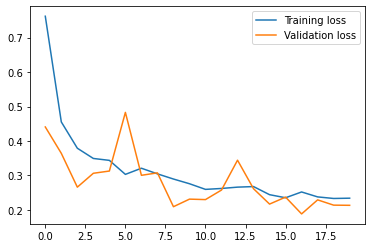

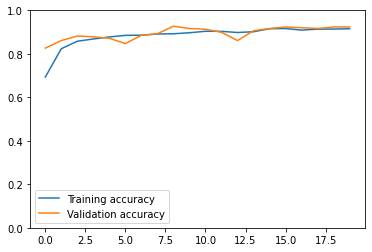

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.8805555555555555
La matriz de confusión de las predicciones ha sido: 
 [[234   1   0]
 [ 15 219  10]
 [ 46  14 181]]


In [ ]:

inputs = keras.layers.Input(shape=[2048])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dense(units=200, activation="relu")(layer1)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer2)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 51s 562ms/step - loss: 0.4157 - acc: 0.8256 - val_loss: 1.4719 - val_acc: 0.3264
Epoch 2/20
81/81 [==============================] - 45s 548ms/step - loss: 0.1192 - acc: 0.9610 - val_loss: 1.7477 - val_acc: 0.3681
Epoch 3/20
81/81 [==============================] - 44s 547ms/step - loss: 0.1046 - acc: 0.9652 - val_loss: 1.8691 - val_acc: 0.3576
Epoch 4/20
81/81 [==============================] - 45s 548ms/step - loss: 0.0765 - acc: 0.9771 - val_loss: 2.0101 - val_acc: 0.3854
Epoch 5/20
81/81 [==============================] - 44s 545ms/step - loss: 0.0610 - acc: 0.9819 - val_loss: 1.8321 - val_acc: 0.4722
Epoch 6/20
81/81 [==============================] - 44s 547ms/step - loss: 0.0494 - acc: 0.9825 - val_loss: 2.4321 - val_acc: 0.3472
Epoch 7/20
81/81 [==============================] - 44s 544ms/step - loss: 0.0459 - acc: 0.9860 - val_loss: 1.5269 - val_acc: 0.6042
Epoch 8/20
81/81 [==============================] - 44s 547ms/step - 

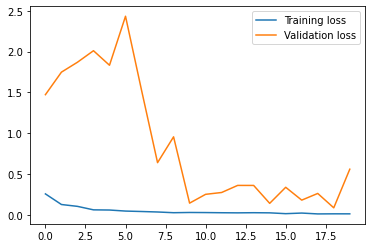

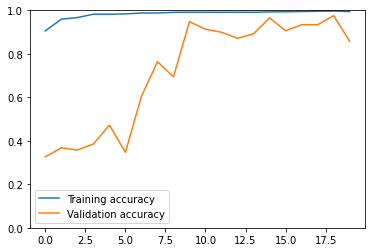

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 7s 9ms/step
La accuracy del modelo es: 0.8736111111111111
La matriz de confusión de las predicciones ha sido: 
 [[173   0  62]
 [  2 220  22]
 [  0   5 236]]


In [ ]:
#Fine Tunning
train_generator, test_generator = generators(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
resnet = ResNet50(include_top=False, weights='imagenet', pooling='avg', )

#Pesos sí entrenables
resnet.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(resnet.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=resnet.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 20,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
#model.summary()
#Clasificamos
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

##**VGG16**

In [ ]:
#Definición inicial de nuestro modelo preentrenado en imagenet.
#Para usarlo como extractor de características simple
from keras.applications import VGG16
#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = VGG16(include_top=False, weights='imagenet', pooling='avg')

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict_generator(train_generator.flow(x_train, batch_size=1, shuffle=False),verbose=1, steps=len(x_train))
car_test = feat_extractor.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

#feat_extractor.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 6s 9ms/step


Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 0.7056 - acc: 0.7070 - val_loss: 0.2211 - val_acc: 0.9375
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2332 - acc: 0.9174 - val_loss: 0.1925 - val_acc: 0.9306
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1894 - acc: 0.9369 - val_loss: 0.1356 - val_acc: 0.9618
Epoch 4/20
81/81 [==============================] - 0s 2ms/step - loss: 0.1570 - acc: 0.9433 - val_loss: 0.1449 - val_acc: 0.9444
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1540 - acc: 0.9411 - val_loss: 0.1296 - val_acc: 0.9549
Epoch 6/20
81/81 [==============================] - 0s 2ms/step - loss: 0.1423 - acc: 0.9491 - val_loss: 0.1443 - val_acc: 0.9444
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1645 - acc: 0.9395 - val_loss: 0.1337 - val_acc: 0.9514
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.1478 - acc: 0.94

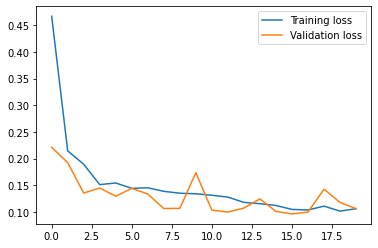

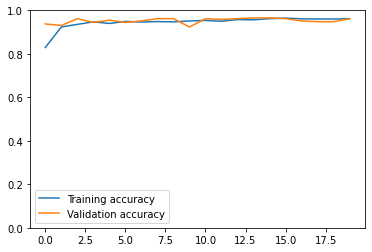

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.9375
La matriz de confusión de las predicciones ha sido: 
 [[234   0   1]
 [  2 232  10]
 [  8  24 209]]


In [ ]:
inputs = keras.layers.Input(shape=[512])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dense(units=200, activation="relu")(layer1)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer2)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 48s 582ms/step - loss: 1.1235 - acc: 0.3683 - val_loss: 1.0955 - val_acc: 0.4861
Epoch 2/20
81/81 [==============================] - 47s 580ms/step - loss: 1.0957 - acc: 0.4055 - val_loss: 1.1017 - val_acc: 0.3160
Epoch 3/20
81/81 [==============================] - 47s 576ms/step - loss: 1.0997 - acc: 0.3430 - val_loss: 1.1018 - val_acc: 0.3160
Epoch 4/20
81/81 [==============================] - 46s 568ms/step - loss: 1.1000 - acc: 0.3383 - val_loss: 1.0994 - val_acc: 0.3264
Epoch 5/20
81/81 [==============================] - 46s 566ms/step - loss: 1.1000 - acc: 0.3274 - val_loss: 1.0986 - val_acc: 0.3160
Epoch 6/20
81/81 [==============================] - 46s 567ms/step - loss: 1.0995 - acc: 0.3133 - val_loss: 1.1019 - val_acc: 0.3160
Epoch 7/20
81/81 [==============================] - 46s 565ms/step - loss: 1.0989 - acc: 0.3371 - val_loss: 1.1006 - val_acc: 0.3160
Epoch 8/20
81/81 [==============================] - 46s 565ms/step - 

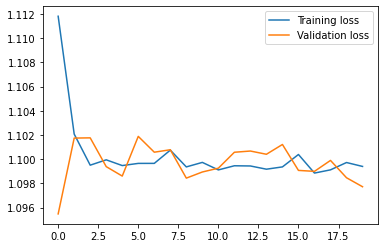

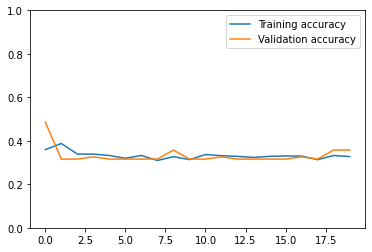

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 6s 9ms/step
La accuracy del modelo es: 0.3388888888888889
La matriz de confusión de las predicciones ha sido: 
 [[  0 235   0]
 [  0 244   0]
 [  0 241   0]]


In [ ]:
from keras.applications import VGG16

#Fine Tunning
train_generator, test_generator = generators(x_train)
#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
VGG16 = VGG16(include_top=False, weights='imagenet', pooling='avg', )

#Pesos sí entrenables
VGG16.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(VGG16.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=VGG16.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 20,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
#model.summary()
#Clasificamos
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

##**InceptionV3**

In [ ]:
#Definición inicial de nuestro modelo preentrenado en imagenet.
#Para usarlo como extractor de características simple

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = InceptionV3(include_top=False, weights='imagenet', pooling='avg', )

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict_generator(train_generator.flow(x_train, batch_size=1, shuffle=False),verbose=1, steps=len(x_train))
car_test = feat_extractor.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

#feat_extractor.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 8s 11ms/step


Epoch 1/20
81/81 [==============================] - 1s 4ms/step - loss: 0.9295 - acc: 0.6045 - val_loss: 0.3761 - val_acc: 0.8611
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.4621 - acc: 0.8188 - val_loss: 0.3220 - val_acc: 0.8924
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 0.4077 - acc: 0.8382 - val_loss: 0.2871 - val_acc: 0.8993
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3827 - acc: 0.8610 - val_loss: 0.2531 - val_acc: 0.9236
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3632 - acc: 0.8729 - val_loss: 0.2764 - val_acc: 0.8958
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3439 - acc: 0.8851 - val_loss: 0.2941 - val_acc: 0.8958
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3107 - acc: 0.8726 - val_loss: 0.2738 - val_acc: 0.8924
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2948 - acc: 0.90

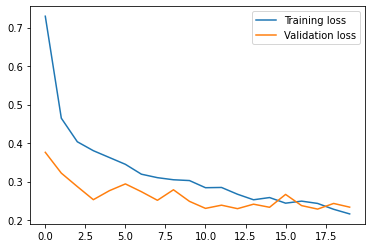

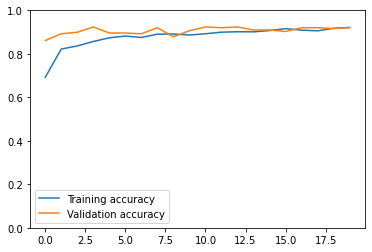

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.8902777777777777
La matriz de confusión de las predicciones ha sido: 
 [[224   4   7]
 [ 17 210  17]
 [ 11  23 207]]


In [ ]:
#En este modelo es necesario regularizar
inputs = keras.layers.Input(shape=[2048])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dropout(0.5)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.5)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])


#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 50s 520ms/step - loss: 0.5101 - acc: 0.7750 - val_loss: 1.0803 - val_acc: 0.6667
Epoch 2/20
81/81 [==============================] - 41s 505ms/step - loss: 0.2113 - acc: 0.9372 - val_loss: 0.0903 - val_acc: 0.9722
Epoch 3/20
81/81 [==============================] - 41s 502ms/step - loss: 0.0891 - acc: 0.9711 - val_loss: 0.1135 - val_acc: 0.9653
Epoch 4/20
81/81 [==============================] - 41s 504ms/step - loss: 0.0609 - acc: 0.9769 - val_loss: 0.2400 - val_acc: 0.8993
Epoch 5/20
81/81 [==============================] - 41s 505ms/step - loss: 0.0806 - acc: 0.9774 - val_loss: 0.3982 - val_acc: 0.8611
Epoch 6/20
81/81 [==============================] - 41s 502ms/step - loss: 0.0486 - acc: 0.9760 - val_loss: 0.0765 - val_acc: 0.9653
Epoch 7/20
81/81 [==============================] - 41s 507ms/step - loss: 0.0512 - acc: 0.9858 - val_loss: 0.0800 - val_acc: 0.9757
Epoch 8/20
81/81 [==============================] - 41s 504ms/step - 

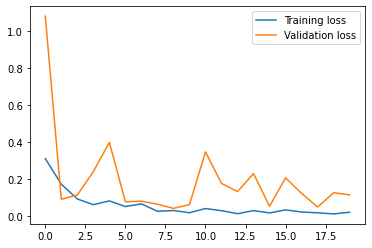

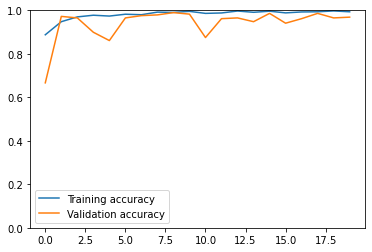

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 9s 11ms/step
La accuracy del modelo es: 0.9791666666666666
La matriz de confusión de las predicciones ha sido: 
 [[233   1   1]
 [  0 243   1]
 [  1  11 229]]


In [ ]:
#Fine Tunning
train_generator, test_generator = generators(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
InceptionV3 = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

#Pesos sí entrenables
InceptionV3.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(InceptionV3.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=InceptionV3.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 20,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
#model.summary()
#Clasificamos
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

#**Xception**

In [ ]:
#Image data generators
train_generator, test_generator = generators(x_train)

#Definición inicial de nuestro modelo preentrenado en imagenet.
#Para usarlo como extractor de características simple

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = Xception(include_top=False, weights='imagenet', pooling='avg' )

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Extraer las características de las imágenes con el modelo anterior.
car_train = feat_extractor.predict_generator(train_generator.flow(x_train, batch_size=1, shuffle=False),verbose=1, steps=len(x_train))
car_test = feat_extractor.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

#feat_extractor.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 6s 8ms/step


Epoch 1/20
81/81 [==============================] - 1s 5ms/step - loss: 0.7670 - acc: 0.6488 - val_loss: 0.2411 - val_acc: 0.9201
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 0.3457 - acc: 0.8709 - val_loss: 0.1915 - val_acc: 0.9479
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2948 - acc: 0.8940 - val_loss: 0.2064 - val_acc: 0.9306
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2787 - acc: 0.8905 - val_loss: 0.1459 - val_acc: 0.9688
Epoch 5/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2408 - acc: 0.9123 - val_loss: 0.1781 - val_acc: 0.9479
Epoch 6/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2324 - acc: 0.9220 - val_loss: 0.1404 - val_acc: 0.9583
Epoch 7/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2446 - acc: 0.9182 - val_loss: 0.1527 - val_acc: 0.9549
Epoch 8/20
81/81 [==============================] - 0s 3ms/step - loss: 0.2019 - acc: 0.93

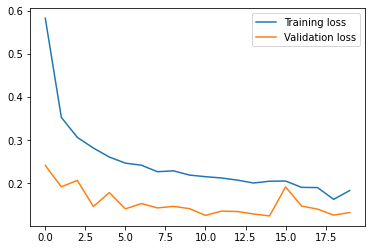

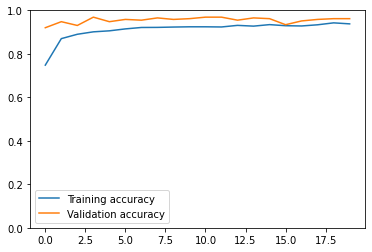

23/23 [==============================] - 0s 1ms/step
La accuracy del modelo es: 0.9152777777777777
La matriz de confusión de las predicciones ha sido: 
 [[231   2   2]
 [  2 223  19]
 [  8  28 205]]


In [ ]:
#En este modelo es necesario regularizar
inputs = keras.layers.Input(shape=[2048])
layer1 = keras.layers.Dense(units=500, activation="relu")(inputs)
layer2 = keras.layers.Dropout(0.5)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.5)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

dense_model = keras.Model(inputs=inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
dense_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])


#Lo entrenamos
hist = dense_model.fit(car_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

#Clasificamos
y_preds = dense_model.predict(car_test, verbose=True)

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 64s 715ms/step - loss: 0.6891 - acc: 0.6808 - val_loss: 0.2911 - val_acc: 0.8924
Epoch 2/20
81/81 [==============================] - 56s 689ms/step - loss: 0.1443 - acc: 0.9517 - val_loss: 0.3091 - val_acc: 0.8924
Epoch 3/20
81/81 [==============================] - 56s 692ms/step - loss: 0.0906 - acc: 0.9630 - val_loss: 0.1127 - val_acc: 0.9792
Epoch 4/20
81/81 [==============================] - 56s 694ms/step - loss: 0.0577 - acc: 0.9829 - val_loss: 0.0832 - val_acc: 0.9757
Epoch 5/20
81/81 [==============================] - 56s 691ms/step - loss: 0.0414 - acc: 0.9865 - val_loss: 0.0587 - val_acc: 0.9826
Epoch 6/20
81/81 [==============================] - 56s 692ms/step - loss: 0.0189 - acc: 0.9965 - val_loss: 0.0712 - val_acc: 0.9861
Epoch 7/20
81/81 [==============================] - 56s 689ms/step - loss: 0.0347 - acc: 0.9916 - val_loss: 0.0892 - val_acc: 0.9688
Epoch 8/20
81/81 [==============================] - 56s 692ms/step - 

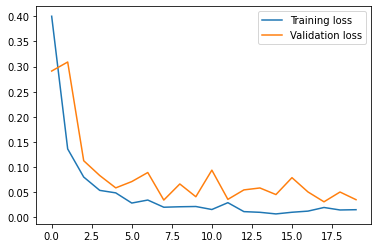

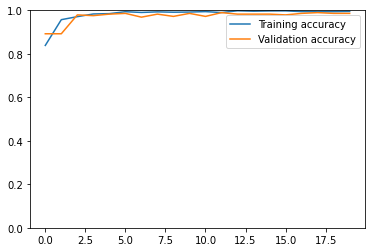

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 6s 8ms/step
La accuracy del modelo es: 0.9875
La matriz de confusión de las predicciones ha sido: 
 [[234   0   1]
 [  0 244   0]
 [  0   8 233]]


In [ ]:
#Fine Tunning
train_generator, test_generator = generators(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
Xception = Xception(include_top=False, weights='imagenet', pooling='avg')

#Pesos sí entrenables
Xception.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(Xception.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=Xception.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 20,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
#model.summary()
#Clasificamos
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

#Mapa de calor

Vamos a visualizar un mapa de calor sobre las regiones de interés en las que la red se ha fijado a la hora de realizar la clasificación. Esto nos va a ser muy útil para entender en qué zonas se está fijando la red para poder realizar sus predicciones. Así podemos ver si realmente está focalizándose en la zona pulmonar, en qué parte de los pulmones se fija más a la hora de hacer la predicción, o si se está fijando en otros lugares de la imagen que no tengan realmente que ver con el problema a resolver pero que tengan una correlación con algunas de las clases y que hagan que el aprendizaje se desvíe.

Primero vamos a definir nuestro modelo, el cual va a ser ResNet50, en vez de DenseNet121, debido a que 

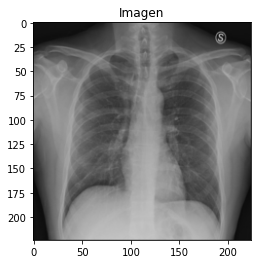

Epoch 1/20
81/81 [==============================] - 12s 119ms/step - loss: 1.5329 - acc: 0.7645 - val_loss: 0.2636 - val_acc: 0.9479
Epoch 2/20
81/81 [==============================] - 9s 110ms/step - loss: 0.2318 - acc: 0.9480 - val_loss: 0.1695 - val_acc: 0.9583
Epoch 3/20
81/81 [==============================] - 9s 111ms/step - loss: 0.1136 - acc: 0.9717 - val_loss: 0.1320 - val_acc: 0.9618
Epoch 4/20
81/81 [==============================] - 9s 112ms/step - loss: 0.0859 - acc: 0.9693 - val_loss: 0.1835 - val_acc: 0.9410
Epoch 5/20
81/81 [==============================] - 9s 113ms/step - loss: 0.0704 - acc: 0.9743 - val_loss: 0.1580 - val_acc: 0.9479
Epoch 6/20
81/81 [==============================] - 9s 112ms/step - loss: 0.0620 - acc: 0.9737 - val_loss: 0.1938 - val_acc: 0.9479
Epoch 7/20
81/81 [==============================] - 9s 112ms/step - loss: 0.0703 - acc: 0.9758 - val_loss: 0.1099 - val_acc: 0.9549
Epoch 8/20
81/81 [==============================] - 9s 111ms/step - loss: 0

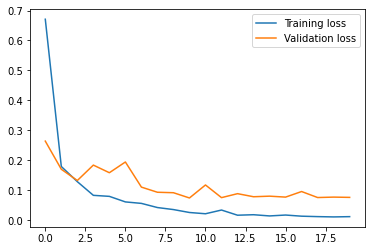

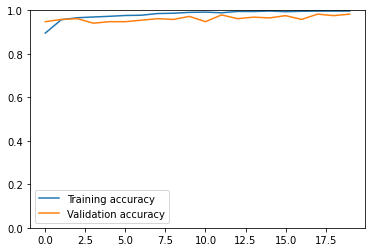

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
feat_extractor = ResNet50(include_top=False, weights='imagenet', pooling='avg')
feat_extractor.trainable = False

#Una vez tenemos el modelo, vamos a compilarlo usando un optimizador y una funcion de perdida
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Con esto tenemos el modelo de densenet hasta que nos deja los datos en forma de vector unidimensional
#de dimensión 1024
feat_extractor = keras.Model(inputs=feat_extractor.inputs, outputs= feat_extractor.layers[-1].output)

feat_extractor.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

pintaI(x_train[0])
#Modelo denso
outputs = keras.layers.Dense(units=3, activation="softmax")(feat_extractor.output)

model = keras.Model(inputs=feat_extractor.inputs, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
mostrarEvolucion(hist)

model.summary()

#Definición del modelo en su conjunto:
total_model = keras.Model(inputs= feat_extractor.inputs, outputs=outputs)


def get_img_array(img, size):
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # Primero vamos a crear un modelo que transforma usando el modelo
    # que hemos pasado en model hasta la última convolución
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Ahora vamos a crear el modelo que coge la salida del modelo anterior y a
    # partir de ella saca las predicciones finales (resto del modelo)
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Ahora lo que vamos a hacer va a ser calcular los gradientes de la clase
    # con mayor probabilidad respecto a las activaciones que ha habido en la última
    # capa convolucional
    with tf.GradientTape() as tape:
        # Se calcula las activaciones de la última capa convolucional, y hacemos watch,
        # necesario para calcular los gradientes
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Ahora calculamos las predicciones
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Este es el gradiente de la clase con mayor probabilidad respecto de los 
    # resultados de la última capa convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vamos a declarar ahora un vector donde ada componente es la intensidad
    # media del gradiente sobre un determinado canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Para visualizarlo mejor, se normaliza el heatmap con valores entre 0 y 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

<Figure size 640x480 with 0 Axes>

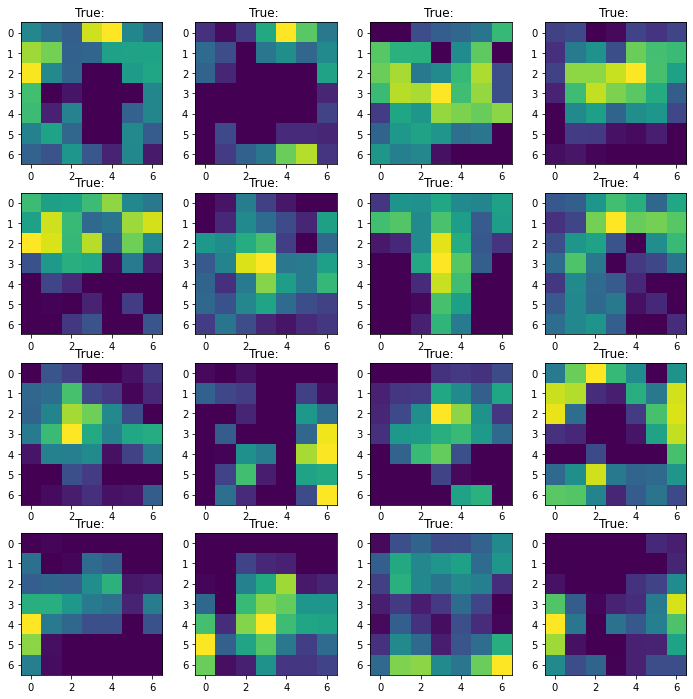

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(12,12))

heatmaps = []

for i in range(16):
  # subplot
  pyplot.subplot(4,4,i+1)
  # Prepare image
  img_array = get_img_array(x_test[i], size=(224,224))

  heatmaps.append(make_gradcam_heatmap(
      img_array, total_model, "conv5_block3_out", ["avg_pool", "dense_4"]
  ))

  pyplot.imshow(heatmaps[i])
  pyplot.title("True: " + str())
pyplot.show()

<Figure size 640x480 with 0 Axes>

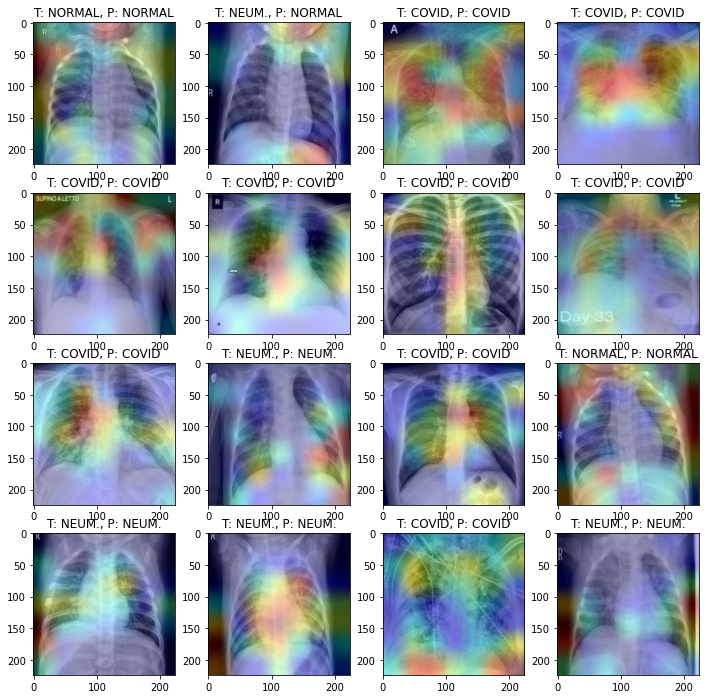

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(12,12))

def MuestraClase(v):
  """
  Devuelve un string con la clase de la imagen, siendo su vector de clases v
  """
  i = np.argmax(v, axis=1)
  if i == 0:
    return "COVID"
  if i == 1:
    return "NORMAL"
  if i == 2:
    return "NEUM."


for i in range(16):
  pyplot.subplot(4,4,i+1)
  # We load the original image
  img = keras.preprocessing.image.img_to_array(x_test[i])

  preds = total_model.predict(get_img_array(x_test[i], size=(224,224)))
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmaps[i])

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  pyplot.imshow(superimposed_img)
  pyplot.title("T: " + MuestraClase([y_test[i]]) + ", P: " + MuestraClase(preds))
  
pyplot.show()

#**Heatmap para Xception**

83689472/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
81/81 [==============================] - 65s 736ms/step - loss: 0.6674 - acc: 0.7199 - val_loss: 0.4312 - val_acc: 0.8576
Epoch 2/3
81/81 [==============================] - 57s 706ms/step - loss: 0.1208 - acc: 0.9599 - val_loss: 0.1635 - val_acc: 0.9549
Epoch 3/3
81/81 [==============================] - 57s 697ms/step - loss: 0.0836 - acc: 0.9764 - val_loss: 0.0635 - val_acc: 0.9792


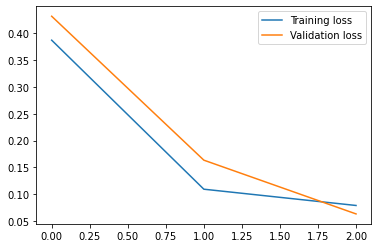

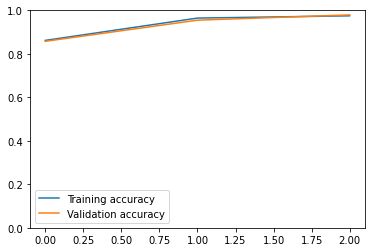

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
#Fine Tunning
#Image data generators
train_generator = ImageDataGenerator(featurewise_center = True,
                             featurewise_std_normalization = True,
                             validation_split=0.1,
                             horizontal_flip=True,
                             brightness_range=[0.8,1.25],
                             zoom_range=[1,1.2])
train_generator.fit(x_train)

test_generator = ImageDataGenerator(featurewise_center = True,
                             featurewise_std_normalization = True)

test_generator.fit(x_train)

#Vamos a cargar el modelo antes del ultimo pooling, para usarlo como extractor de caracteristicas
Xception = Xception(include_top=False, weights='imagenet', pooling='avg')

#Pesos sí entrenables
Xception.trainable = True

#Modelo denso
layer1 = keras.layers.Dense(units=500, activation="relu")(Xception.output)
layer2 = keras.layers.Dropout(0.25)(layer1)
layer3 = keras.layers.Dense(units=200, activation="relu")(layer2)
layer4 = keras.layers.Dropout(0.25)(layer3)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer4)

model = keras.Model(inputs=Xception.input, outputs=outputs)
opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

#Lo entrenamos
hist = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                                  steps_per_epoch = len(x_train)*0.9/32,
                                  epochs = 3,
                                  validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                                  validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(hist)
model.summary()

#Definición del modelo en su conjunto:
total_model = model

def get_img_array(img, size):
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # Primero vamos a crear un modelo que transforma usando el modelo
    # que hemos pasado en model hasta la última convolución
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Ahora vamos a crear el modelo que coge la salida del modelo anterior y a
    # partir de ella saca las predicciones finales (resto del modelo)
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Ahora lo que vamos a hacer va a ser calcular los gradientes de la clase
    # con mayor probabilidad respecto a las activaciones que ha habido en la última
    # capa convolucional
    with tf.GradientTape() as tape:
        # Se calcula las activaciones de la última capa convolucional, y hacemos watch,
        # necesario para calcular los gradientes
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Ahora calculamos las predicciones
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Este es el gradiente de la clase con mayor probabilidad respecto de los 
    # resultados de la última capa convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vamos a declarar ahora un vector donde ada componente es la intensidad
    # media del gradiente sobre un determinado canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Para visualizarlo mejor, se normaliza el heatmap con valores entre 0 y 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

<Figure size 640x480 with 0 Axes>

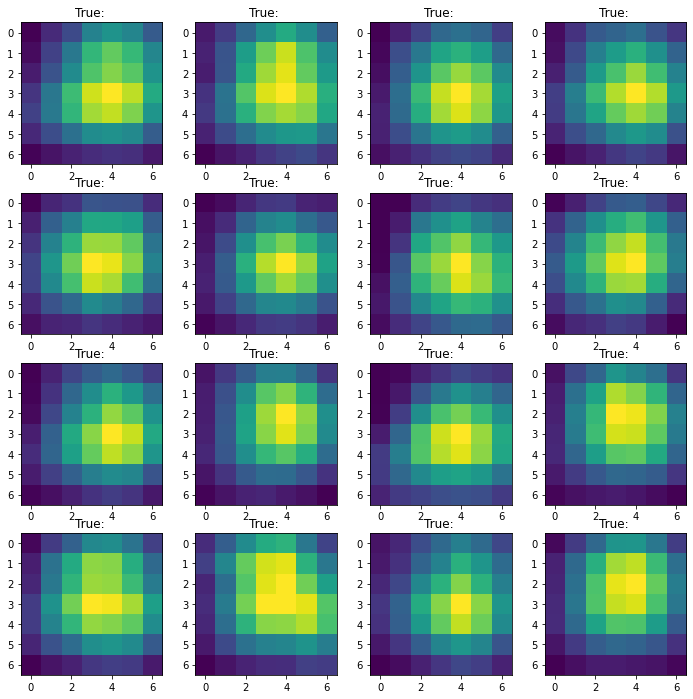

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(12,12))

heatmaps = []

for i in range(16):
  # subplot
  pyplot.subplot(4,4,i+1)
  # Prepare image
  img_array = get_img_array(x_test[i], size=(224,224))

  heatmaps.append(make_gradcam_heatmap(
      img_array, total_model, "block14_sepconv2_act", ["global_average_pooling2d", "dense_6"]
  ))

  pyplot.imshow(heatmaps[i])
  pyplot.title("True: " + str())
pyplot.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 640x480 with 0 Axes>

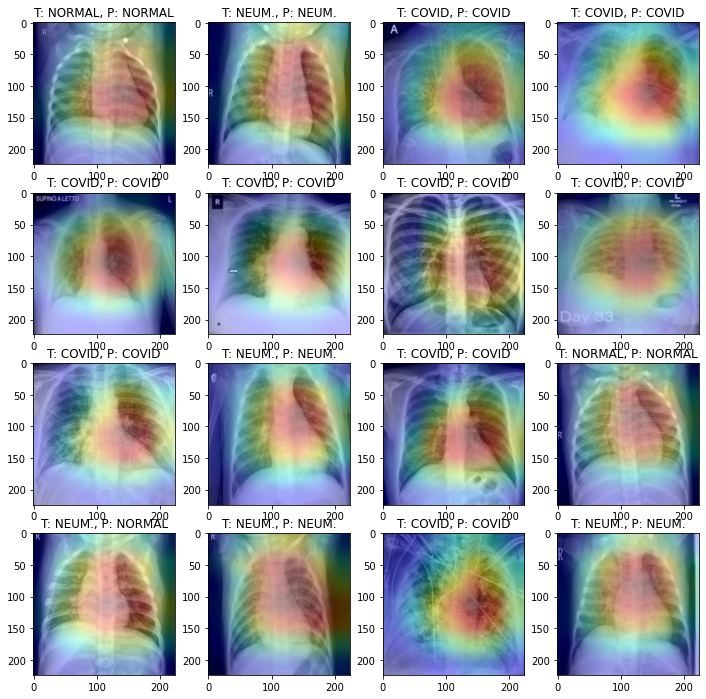

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(12,12))

def MuestraClase(v):
  """
  Devuelve un string con la clase de la imagen, siendo su vector de clases v
  """
  i = np.argmax(v, axis=1)
  if i == 0:
    return "COVID"
  if i == 1:
    return "NORMAL"
  if i == 2:
    return "NEUM."


for i in range(16):
  pyplot.subplot(4,4,i+1)
  # We load the original image
  img = keras.preprocessing.image.img_to_array(x_test[i])

  preds = model.predict_generator(test_generator.flow(get_img_array(x_test[i], size=(224,224))))
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmaps[i])

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  pyplot.imshow(superimposed_img)
  pyplot.title("T: " + MuestraClase([y_test[i]]) + ", P: " + MuestraClase(preds))
  
pyplot.show()

##Mapas de activación

Vamos a ver los mapas de activación para intentar detectar qué regiones de la imagen de entrada son las que se fija la red para dar la salida que da. Vamos a probar sobre el modelo basado en Xception

Usaremos las herramientas que nos proporciona keract.

In [ ]:
pip install keract

block1_conv2 (1, 109, 109, 64) 


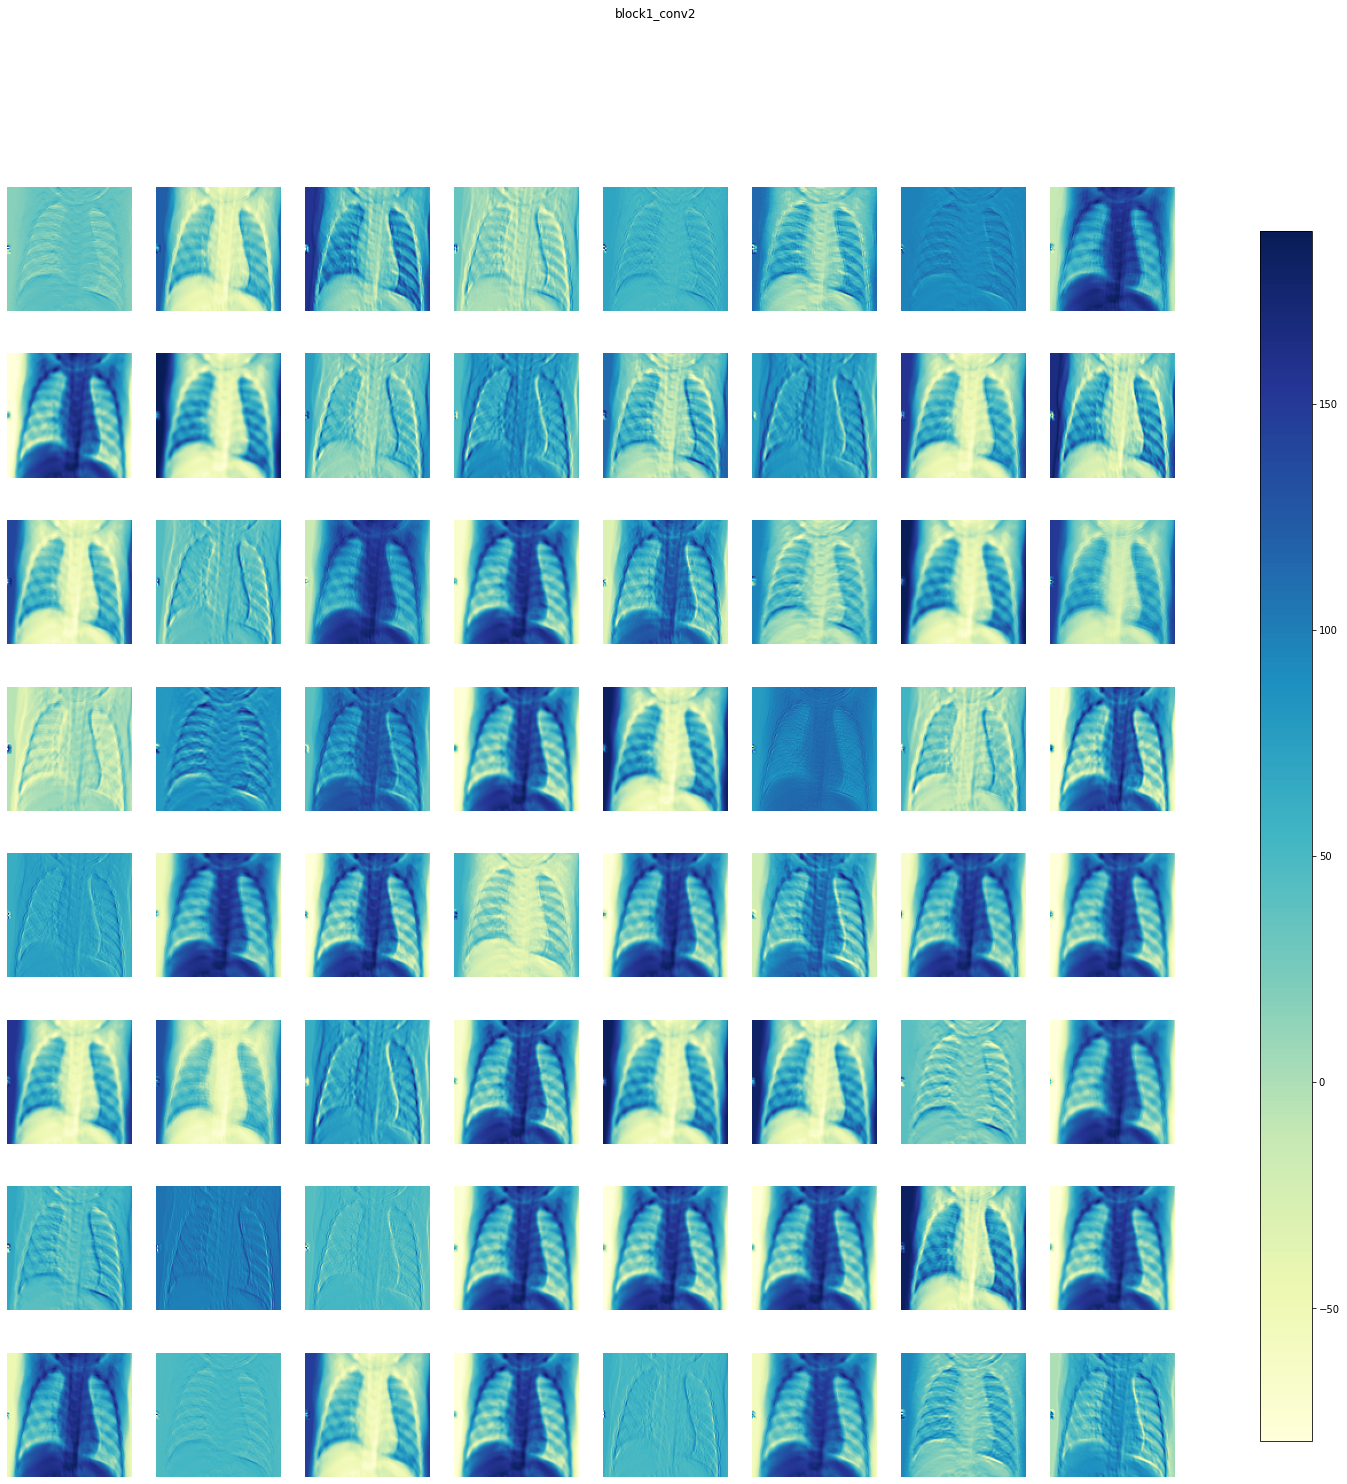

block3_sepconv1_act (1, 55, 55, 128) 


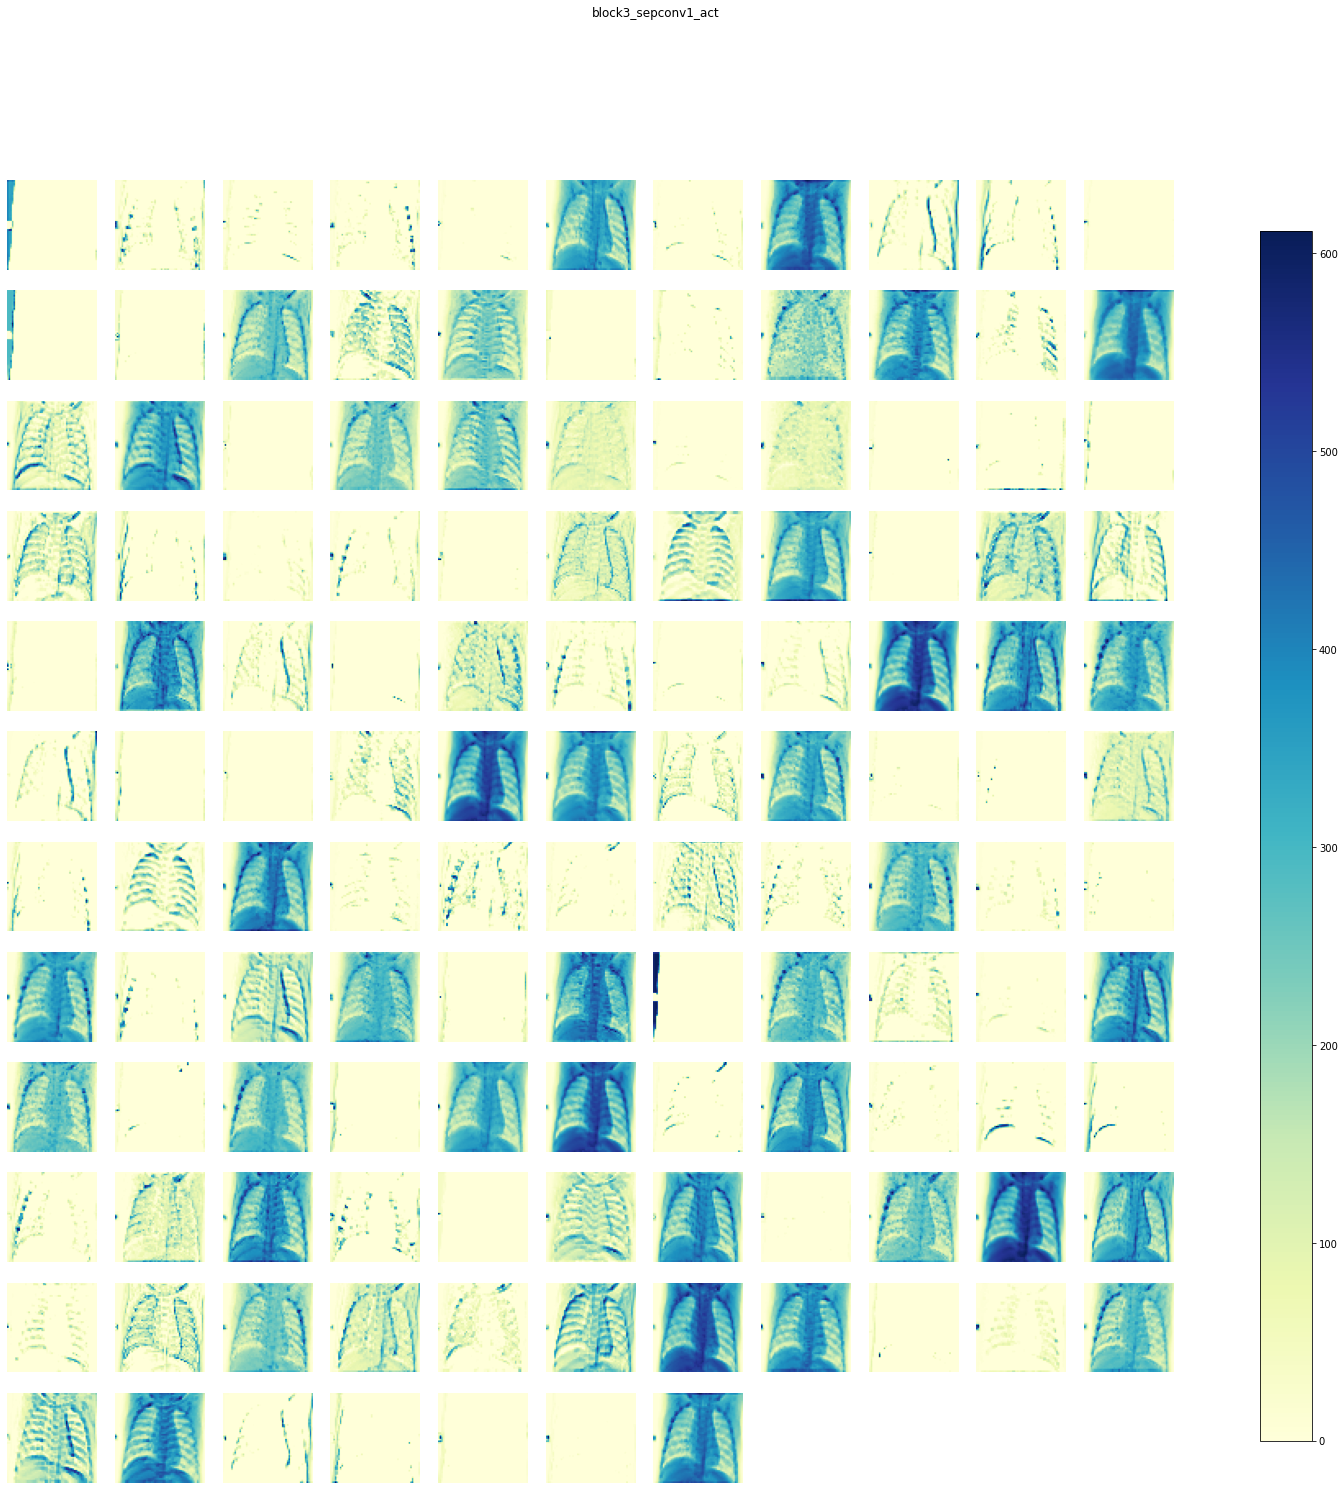

conv2d_14 (1, 14, 14, 728) 


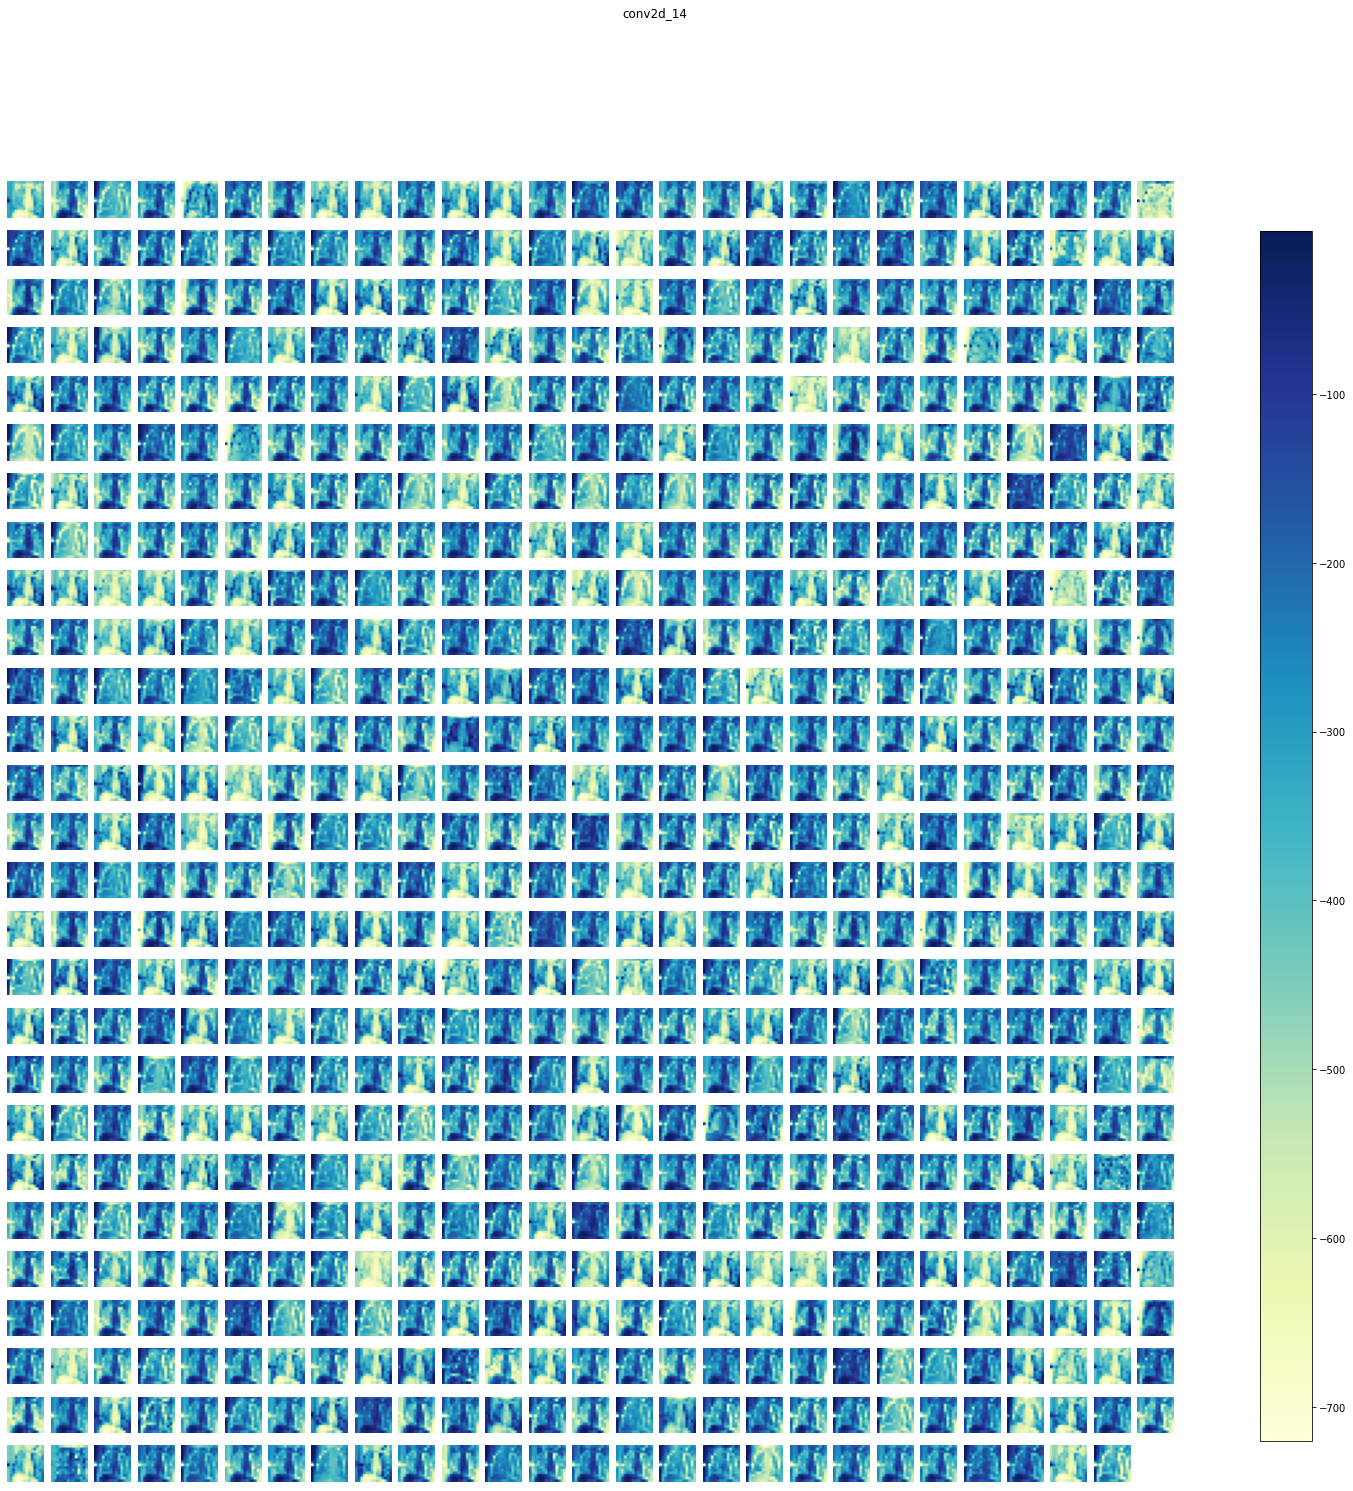

block14_sepconv2_act (1, 7, 7, 2048) 


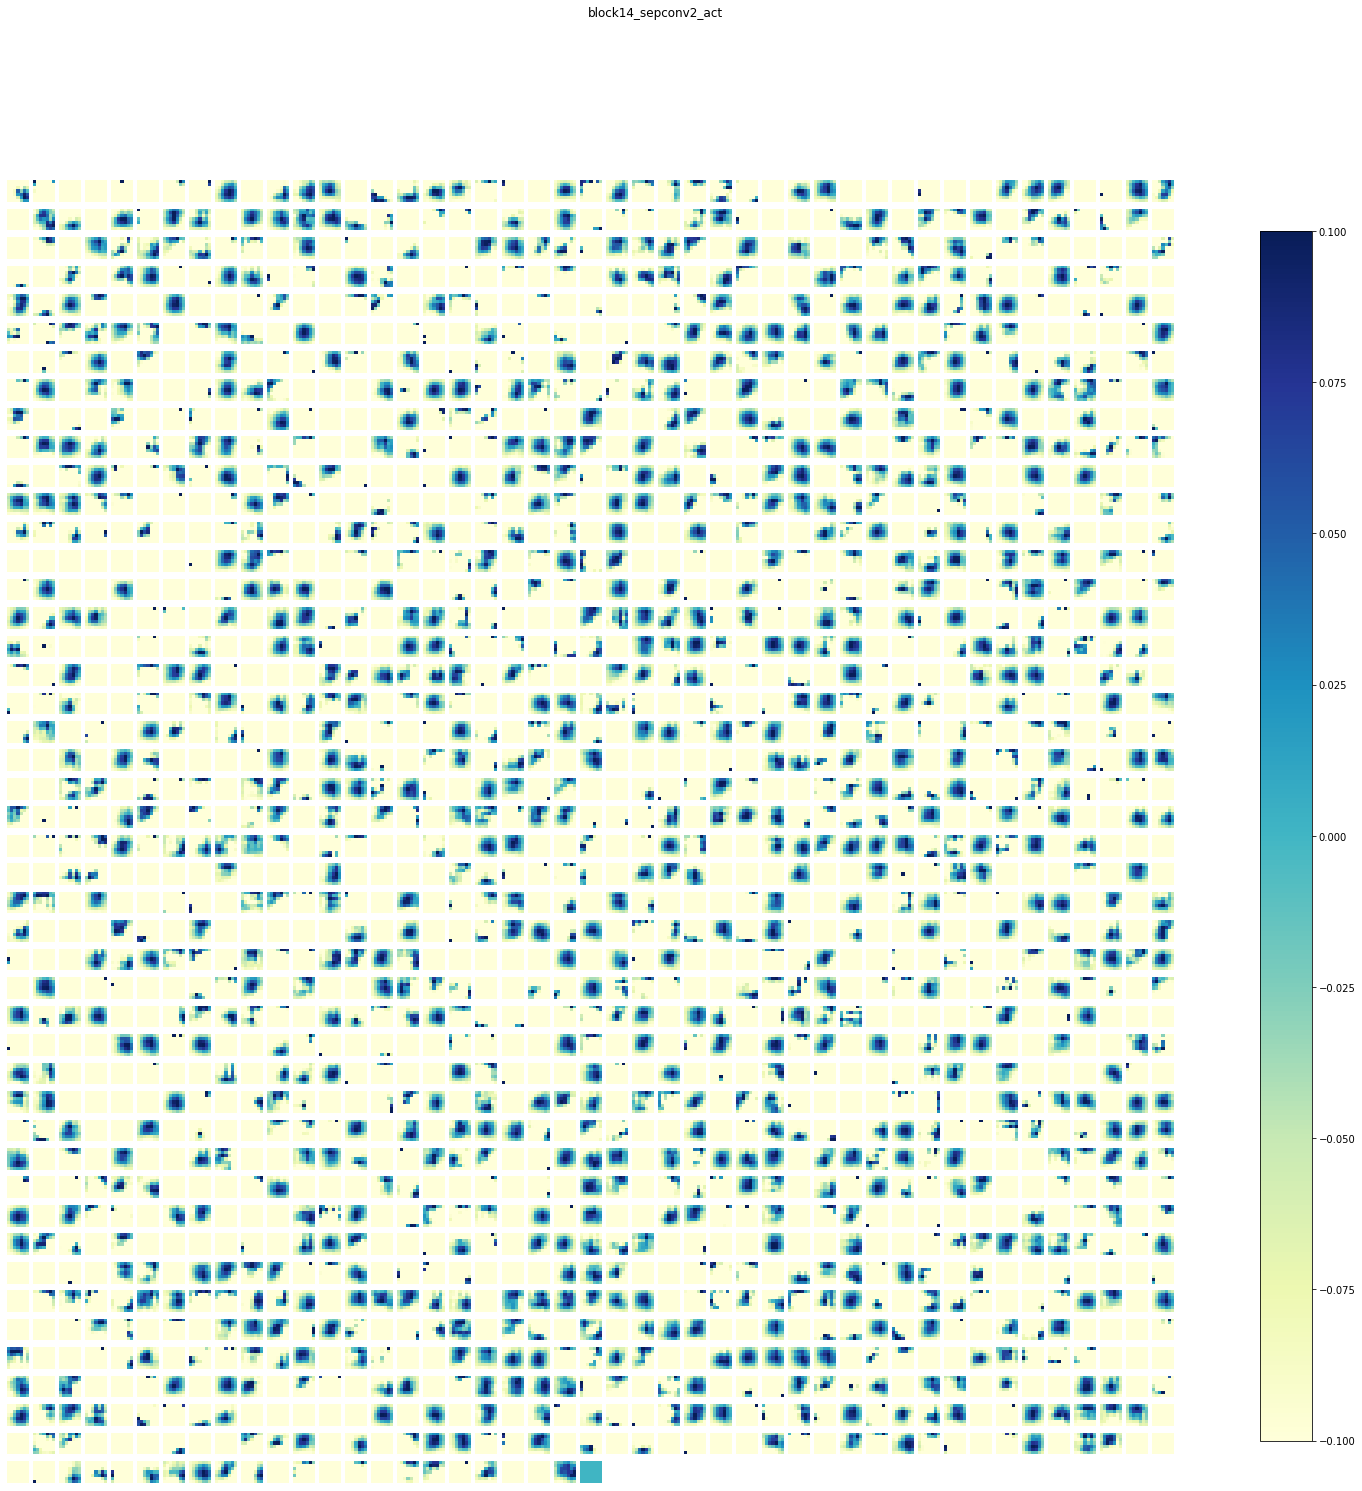

In [ ]:

from keras import activations
from keract import get_activations, display_heatmaps, display_activations

keract_inputs = x_test[1:2]
keract_targets = y_test[:0]
activations = get_activations(model, keract_inputs, layer_names=['block1_conv2', 'block3_sepconv1_act','conv2d_14','block14_sepconv2_act'])
display_activations(activations=activations,cmap='YlGnBu')


# Red from scratch

Vamos a usar ahora la red que utilizó David en el bonus de la práctica 2 también para hacer comparaciones con las demás redes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 49s 533ms/step - loss: 1.4038 - acc: 0.6631 - val_loss: 0.7180 - val_acc: 0.6840
Epoch 2/20
81/81 [==============================] - 43s 524ms/step - loss: 0.1923 - acc: 0.9337 - val_loss: 0.9882 - val_acc: 0.6632
Epoch 3/20
81/81 [==============================] - 42s 516ms/step - loss: 0.1345 - acc: 0.9560 - val_loss: 0.6700 - val_acc: 0.7396
Epoch 4/20
81/81 [==============================] - 42s 517ms/step - loss: 0.1232 - acc: 0.9530 - val_loss: 0.2835 - val_acc: 0.8958
Epoch 5/20
81/81 [==============================] - 42s 518ms/step - loss: 0.1085 - acc: 0.9625 - val_loss: 0.1893 - val_acc: 0.9340
Epoch 6/20
81/81 [==============================] - 42s 517ms/step - loss: 0.0966 - acc: 0.9690 - val_loss: 0.1720 - val_acc: 0.9306
Epoch 7/20
81/81 [==============================] - 42s 515ms/step - loss: 0.1082 - acc: 0.9559 - val_loss: 0.1449 - val_acc: 0.9479
Epoch 8/20
81/81 [==============================] - 42s 518ms/step - 

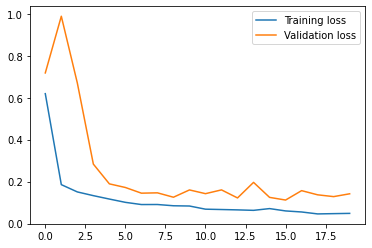

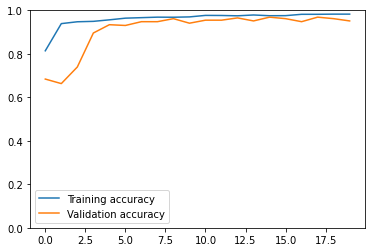

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


720/720 [==============================] - 7s 8ms/step
La accuracy del modelo es: 0.9138888888888889
La matriz de confusión de las predicciones ha sido: 
 [[229   0   6]
 [  3 199  42]
 [ 10   1 230]]


In [ ]:
def resblock(inputs, dim):
  """
  El numero de canales (dim) debe ser multiplo de 3
  """
  bn_1 = keras.layers.BatchNormalization()(inputs)
  #n*n*dim
  input_tr = keras.layers.Conv2D(dim/3,1)(bn_1)
  bn_2 = keras.layers.BatchNormalization()(input_tr)

  #n*n*dim/3
  res_3x_1 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_2)
  bn_3x_1 = keras.layers.BatchNormalization()(res_3x_1)
  act_3x =keras.layers.Activation('relu')(bn_3x_1)
  
  res_5x_1 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_2)
  bn_5x_1 = keras.layers.BatchNormalization()(res_5x_1)
  res_5x_2 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_5x_1)
  bn_5x_2 = keras.layers.BatchNormalization()(res_5x_2)
  act_5x =keras.layers.Activation('relu')(bn_5x_2)
  
  res_7x_1 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_2)
  bn_7x_1 = keras.layers.BatchNormalization()(res_7x_1)
  res_7x_2 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_7x_1)
  bn_7x_2 = keras.layers.BatchNormalization()(res_7x_2)
  res_7x_3 = keras.layers.Conv2D(dim/3,3,padding='same')(bn_7x_2)
  bn_7x_3 = keras.layers.BatchNormalization()(res_7x_3)
  act_7x =keras.layers.Activation('relu')(bn_7x_3)
  concat = keras.layers.Concatenate()([act_3x, act_5x, act_7x])
  #n*n*dim
  output = keras.layers.Add()([bn_1, concat])                     #parte residual
  
  return output




#Image data generators
train_generator = ImageDataGenerator(featurewise_center = True,
                             featurewise_std_normalization = True,
                             validation_split=0.1,
                             horizontal_flip=True,
                             brightness_range=[0.8,1.25],
                             zoom_range=[1,1.2])
train_generator.fit(x_train)

test_generator = ImageDataGenerator(featurewise_center = True,
                             featurewise_std_normalization = True)

test_generator.fit(x_train)


train_generator.fit(x_train)
test_generator.fit(x_train)

#La red neuronal va a tener las siguientes caracteristicas
    # - El enfoque de la red sera muy parecido al de resnet
    # - Tendra varios modulos residuales, pero en cada uno se calcularan filtros independientes
    # - Se calculara una serie de filtros 3*3, otros de 2 niveles 3*3, y otra de 3 niveles 3*3
    #   (con activacion solo al final)
    # - Se utilizara padding para que los tamanos de estas convoluciones independientes sean comparables
    # - Se hara max pooling con tamano de filtro 2*2 tras cada ciclo de bloques residuales
    # - Ademas incluiremos informacion de capas anteriores a las capas siguientes, aplicando un
    #   convoluciones y luego submuestreando
    

# OJO, La red inicial estaba preparada para una entrada de 32*32*3.
# Se adapta para una entrada de 224*224*3, los cambios se especifican en el documento

inputs = keras.layers.Input(shape=(224,224,3))

#PRIMER BLOQUE
input_1 = keras.layers.Conv2D(9, 1)(inputs)
# 224*224*9

bloq_1_1 = resblock(input_1, 9)
bloq_1_2 = resblock(bloq_1_1, 9)

pool_1 = keras.layers.MaxPool2D()(bloq_1_2)
# 112*112*9


#SEGUNDO BLOQUE
#En la entrada no aplicaremos activacion, solo queremos informacion de capas anteriores
#Resultados del pooling anterior, ampliando canales
res_pool_1 = keras.layers.Conv2D(18, 1)(pool_1)
#Informacion inicial del bloque 1
conv_1b_1 = keras.layers.Conv2D(3, 3, padding='same')(input_1)
bn_1b_1 = keras.layers.BatchNormalization()(conv_1b_1)
pool_1b_1 = keras.layers.MaxPool2D()(bn_1b_1)
input_2 = keras.layers.Concatenate()([res_pool_1, pool_1b_1])
# 112*112*21

bloq_2_1 = resblock(input_2, 21)
bloq_2_2 = resblock(bloq_2_1, 21)

pool_2 = keras.layers.MaxPool2D()(bloq_2_2)
# 56*56*21


#TERCER BLOQUE
#Resultados del pooling anterior, ampliando canales
res_pool_2 = keras.layers.Conv2D(30, 1)(pool_2)
#Informacion inicial del bloque 1
conv_1b_2 = keras.layers.Conv2D(3, 3, padding='same')(pool_1b_1)
bn_1b_2 = keras.layers.BatchNormalization()(conv_1b_2)
pool_1b_2 = keras.layers.MaxPool2D()(bn_1b_2)
#Informacion inicial del bloque 2
conv_2b_1 = keras.layers.Conv2D(3, 3, padding='same')(input_2)
bn_2b_1 = keras.layers.BatchNormalization()(conv_2b_1)
pool_2b_1 = keras.layers.MaxPool2D()(bn_2b_1)
input_3 = keras.layers.Concatenate()([res_pool_2, pool_1b_2, pool_2b_1])
# 56*56*36

bloq_3_1 = resblock(input_3, 36)
bloq_3_2 = resblock(bloq_3_1, 36)

pool_3 = keras.layers.MaxPool2D()(bloq_3_2)
# 28*28*36

#Resultados del pooling anterior, ampliando canales
res_pool_3 = keras.layers.Conv2D(45, 1)(pool_3)
#Informacion inicial del bloque 1
conv_1b_3 = keras.layers.Conv2D(3, 3, padding='same')(pool_1b_2)
bn_1b_3 = keras.layers.BatchNormalization()(conv_1b_3)
pool_1b_3 = keras.layers.MaxPool2D()(bn_1b_3)
#Informacion inicial del bloque 2
conv_2b_2 = keras.layers.Conv2D(3, 3, padding='same')(pool_2b_1)
bn_2b_2 = keras.layers.BatchNormalization()(conv_2b_2)
pool_2b_2 = keras.layers.MaxPool2D()(bn_2b_2)
#Informacion inicial del bloque 3
conv_3b_1 = keras.layers.Conv2D(3, 3, padding='same')(input_3)
bn_3b_1 = keras.layers.BatchNormalization()(conv_3b_1)
pool_3b_1 = keras.layers.MaxPool2D()(bn_3b_1)
input_4 = keras.layers.Concatenate()([res_pool_3, pool_1b_3, pool_2b_2, pool_3b_1])

# 28*28*54
bloq_4_1 = resblock(input_4, 54)
bloq_4_2 = resblock(bloq_4_1, 54)

pool_4 = keras.layers.MaxPool2D()(bloq_4_2)
# 14*14*54

#Resultados del pooling anterior, ampliando canales
res_pool_4 = keras.layers.Conv2D(63, 1)(pool_4)
#Informacion inicial del bloque 1
conv_1b_4 = keras.layers.Conv2D(3, 3, padding='same')(pool_1b_3)
bn_1b_4 = keras.layers.BatchNormalization()(conv_1b_4)
pool_1b_4 = keras.layers.MaxPool2D()(bn_1b_4)
#Informacion inicial del bloque 2
conv_2b_3 = keras.layers.Conv2D(3, 3, padding='same')(pool_2b_2)
bn_2b_3 = keras.layers.BatchNormalization()(conv_2b_3)
pool_2b_3 = keras.layers.MaxPool2D()(bn_2b_3)
#Informacion inicial del bloque 3
conv_3b_2 = keras.layers.Conv2D(3, 3, padding='same')(pool_3b_1)
bn_3b_2 = keras.layers.BatchNormalization()(conv_3b_2)
pool_3b_2 = keras.layers.MaxPool2D()(bn_3b_2)
#Informacion inicial del bloque 4
conv_4b_1 = keras.layers.Conv2D(3, 3, padding='same')(input_4)
bn_4b_1 = keras.layers.BatchNormalization()(conv_4b_1)
pool_4b_1 = keras.layers.MaxPool2D()(bn_4b_1)
input_5 = keras.layers.Concatenate()([res_pool_4, pool_1b_4, pool_2b_3, pool_3b_2, pool_4b_1])

# 14*14*75
pool_5 = keras.layers.MaxPool2D()(input_5)
# 7*7*75

#BLOQUE DENSO
flatten = keras.layers.Flatten()(pool_5)
# 3675
dense1 = keras.layers.Dense(30, activation='relu')(flatten)
# 30
outputs = keras.layers.Dense(3, activation="softmax")(dense1)
# 3 salidas, 1 para cada clase

model = keras.Model(inputs=inputs, outputs=outputs)

opt = SGD(lr=0.01, decay= 1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size = 32, subset = 'training'),
                              steps_per_epoch = len(x_train)*0.9/32,
                              epochs = 20,
                              validation_data = train_generator.flow(x_train, y_train, batch_size = 32, subset = 'validation'),
                              validation_steps = len(x_train)*0.1/32)

mostrarEvolucion(history)

#Predicción
y_preds = model.predict_generator(test_generator.flow(x_test, batch_size=1, shuffle=False),verbose=1, steps=len(x_test))

print("La accuracy del modelo es: " + str(calcularAccuracy(y_test, y_preds)))

y_test_conf = np.argmax(y_test, axis=1)
y_preds = np.argmax(y_preds, axis=1)
print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, y_preds))

Probamos ahora el modelo de Alberto diseñado para la práctica 2, que es un modelo secuencial más sencillo con menos parámetros

Epoch 1/20
41/41 [==============================] - 46s 1s/step - loss: 1.9564 - acc: 0.6212 - val_loss: 1.2936 - val_acc: 0.7778
Epoch 2/20
41/41 [==============================] - 44s 1s/step - loss: 0.8064 - acc: 0.8424 - val_loss: 0.8850 - val_acc: 0.8299
Epoch 3/20
41/41 [==============================] - 44s 1s/step - loss: 0.7354 - acc: 0.8706 - val_loss: 1.7166 - val_acc: 0.7014
Epoch 4/20
41/41 [==============================] - 44s 1s/step - loss: 0.8509 - acc: 0.8768 - val_loss: 0.6039 - val_acc: 0.9132
Epoch 5/20
41/41 [==============================] - 44s 1s/step - loss: 0.4956 - acc: 0.9303 - val_loss: 0.5909 - val_acc: 0.8924
Epoch 6/20
41/41 [==============================] - 44s 1s/step - loss: 0.4340 - acc: 0.9185 - val_loss: 0.4863 - val_acc: 0.8889
Epoch 7/20
41/41 [==============================] - 44s 1s/step - loss: 0.3135 - acc: 0.9362 - val_loss: 0.8183 - val_acc: 0.8194
Epoch 8/20
41/41 [==============================] - 44s 1s/step - loss: 0.3538 - acc: 0.91

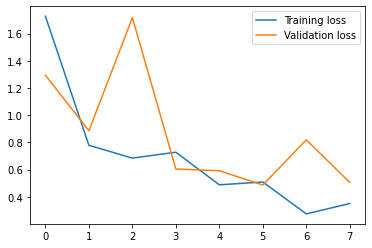

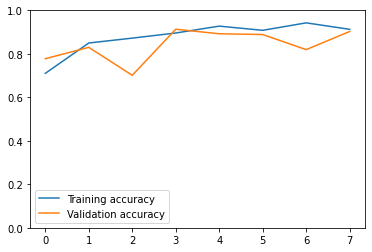

La matriz de confusión de las predicciones ha sido: 
 [[222   7   6]
 [  1 233  10]
 [  5  15 221]]
Test accuracy:  0.9388888888888889


In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import initializers
from keras import backend as K
import time
from keras.layers import LeakyReLU

def DA3_EarlyStopping(modelo, weights, x_train, y_train, x_test, y_test, epochs, batch_size):

    train_generator, test_generator = generators(x_train)

    monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)

    modelo.set_weights(weights)
    
    hist = modelo.fit(train_generator.flow(x_train,
                                                y_train,
                                                batch_size = batch_size,
                                                subset = 'training'),
                                validation_data = train_generator.flow(x_train,
                                                                 y_train,
                                                                 batch_size = batch_size,
                                                                 subset = 'validation'),
                                epochs = epochs,
                                callbacks = [monitor])
                        
    mostrarEvolucion(hist)
    

    
    predicciones = modelo.predict(test_generator
                                  
                                  .flow(x_test,
                                                                 batch_size = 1,
                                                                 shuffle = False),
                                            steps = len(x_test))
    
    acc_test = calcularAccuracy(y_test, predicciones)
    #modelo.summary()
    y_test_conf = np.argmax(y_test, axis=1)
    predicciones = np.argmax(predicciones, axis=1)
    print("La matriz de confusión de las predicciones ha sido: \n", confusion_matrix(y_test_conf, predicciones)) 
    print("Test accuracy: ", acc_test)




def Modelo_Bonus_1():
    
    modelo_bonus = Sequential()
    modelo_bonus.add(Conv2D(60, (3, 3), padding='same', kernel_initializer='orthogonal', input_shape=(224,224,3)))
    modelo_bonus.add(LeakyReLU(alpha=0.1))
    modelo_bonus.add(BatchNormalization(renorm=True))
    modelo_bonus.add(Conv2D(60, (3, 3), padding='same', kernel_initializer='orthogonal'))
    modelo_bonus.add(LeakyReLU(alpha=0.1))
    modelo_bonus.add(BatchNormalization(renorm=True))
    modelo_bonus.add(MaxPooling2D(pool_size=(2, 2)))
    modelo_bonus.add(Dropout(0.25))
    modelo_bonus.add(Conv2D(120, (3, 3), kernel_initializer='orthogonal'))
    modelo_bonus.add(LeakyReLU(alpha=0.1))
    modelo_bonus.add(BatchNormalization(renorm=True))
    modelo_bonus.add(Conv2D(120, (3, 3), kernel_initializer='orthogonal'))
    modelo_bonus.add(LeakyReLU(alpha=0.1))
    modelo_bonus.add(BatchNormalization(renorm=True))
    modelo_bonus.add(MaxPooling2D(pool_size=(2, 2)))
    modelo_bonus.add(Dropout(0.25))
    modelo_bonus.add(Flatten())
    modelo_bonus.add(Dense(600, kernel_initializer='orthogonal'))
    modelo_bonus.add(LeakyReLU(alpha=0.1))
    modelo_bonus.add(BatchNormalization(renorm=True))
    modelo_bonus.add(Dropout(0.5))
    modelo_bonus.add(Dense(3, activation='softmax'))
    #########################################################################
    ######### DEFINICIÓN DEL OPTIMIZADOR Y COMPILACIÓN DEL MODELO ###########
    #########################################################################
    opt = SGD(lr=0.001, decay= 1e-6, momentum=0.9, nesterov=True)
    modelo_bonus.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    
    # Una vez tenemos el modelo base, y antes de entrenar, vamos a guardar los
    # pesos aleatorios con los que empieza la red, para poder reestablecerlos
    # después y comparar resultados entre no usar mejoras y sí usarlas.
    

    
    
    weights = modelo_bonus.get_weights()
    
  
    return modelo_bonus, weights, x_train, y_train, x_test, y_test


modelo_bonus_1, weights, x_train, y_train, x_test, y_test = Modelo_Bonus_1()

batch_size = 64
DA3_EarlyStopping(modelo_bonus_1, weights, x_train, y_train, x_test, y_test, 20, batch_size)